<a href="https://colab.research.google.com/github/Irin-Bino/Task-1-big-data-analysis/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("COVID-19 Big Data Analysis") \
    .getOrCreate()


In [4]:
# Load data from GitHub
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-01-2021.csv"
file_name = "07-01-2021.csv"

# Download the file locally
!wget -O {file_name} {url}

# Read the downloaded file with Spark
df = spark.read.csv(file_name, header=True, inferSchema=True)
df.show(5)
df.printSchema()

--2025-07-16 06:36:00--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-01-2021.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 558761 (546K) [text/plain]
Saving to: ‘07-01-2021.csv’

07-01-2021.csv      100%[===================>] 545.67K  --.-KB/s    in 0.007s  

2025-07-16 06:36:00 (78.0 MB/s) - ‘07-01-2021.csv’ saved [558761/558761]

+----+------+--------------+--------------+-------------------+--------+---------+---------+------+---------+------+------------+------------------+-------------------+
|FIPS|Admin2|Province_State|Country_Region|        Last_Update|     Lat|    Long_|Confirmed|Deaths|Recovered|Active|Combined_Key|     Incident_Rate|Case_Fatality_Ratio|
+----+------+------

In [5]:
from pyspark.sql.functions import col, sum as _sum

# Select useful columns
df = df.select("Country_Region", "Confirmed", "Deaths", "Recovered")

# Filter out nulls
df = df.na.drop()


In [6]:
confirmed_df = df.groupBy("Country_Region").agg(_sum("Confirmed").alias("Total_Confirmed"))
confirmed_df.orderBy(col("Total_Confirmed").desc()).show(10)


+--------------+---------------+
|Country_Region|Total_Confirmed|
+--------------+---------------+
|         India|       30458251|
|        Brazil|       18631426|
|        France|        5840067|
|        Russia|        5472722|
|        Turkey|        5430940|
|United Kingdom|        4844879|
|     Argentina|        4491551|
|      Colombia|        4269297|
|         Italy|        4260788|
|         Spain|        3821305|
+--------------+---------------+
only showing top 10 rows



In [7]:
death_df = df.groupBy("Country_Region").agg(_sum("Deaths").alias("Total_Deaths"))
death_df.orderBy(col("Total_Deaths").desc()).show(10)


+--------------+------------+
|Country_Region|Total_Deaths|
+--------------+------------+
|        Brazil|      520420|
|         India|      400312|
|        Mexico|      233248|
|          Peru|      192687|
|United Kingdom|      155010|
|        Russia|      133633|
|         Italy|      127587|
|        France|      111288|
|      Colombia|      107137|
|     Argentina|       94772|
+--------------+------------+
only showing top 10 rows



In [8]:
rate_df = df.groupBy("Country_Region").agg(
    _sum("Confirmed").alias("Total_Confirmed"),
    _sum("Deaths").alias("Total_Deaths")
).withColumn("Death_Rate", col("Total_Deaths") / col("Total_Confirmed") * 100)

rate_df.orderBy(col("Death_Rate").desc()).filter(col("Total_Confirmed") > 1000).show(10)


+--------------------+---------------+------------+------------------+
|      Country_Region|Total_Confirmed|Total_Deaths|        Death_Rate|
+--------------------+---------------+------------+------------------+
|               Yemen|           6923|        1361|19.659107323414705|
|                Peru|        2057554|      192687|  9.36485749584215|
|              Mexico|        2525350|      233248| 9.236264280198785|
|               Sudan|          36658|        2760| 7.529052321457799|
|               Syria|          25551|        1879| 7.353919611756879|
|               Egypt|         281524|       16194|5.7522626845313365|
|             Somalia|          14946|         775| 5.185333868593603|
|Bosnia and Herzeg...|         205032|        9667| 4.714873775800851|
|             Ecuador|         459538|       21605| 4.701461032602309|
|             Taiwan*|          14853|         661|  4.45027940483404|
+--------------------+---------------+------------+------------------+
only s

In [9]:
recovered_df = df.groupBy("Country_Region").agg(_sum("Recovered").alias("Total_Recovered"))
recovered_df.orderBy(col("Total_Recovered").desc()).show(10)

+--------------+---------------+
|Country_Region|Total_Recovered|
+--------------+---------------+
|         India|       29548302|
|        Brazil|       16477253|
|        Turkey|        5300504|
|        Russia|        4958951|
|     Argentina|        4092053|
|         Italy|        4083843|
|      Colombia|        3964074|
|       Germany|        3625010|
|          Iran|        2889939|
|        Poland|        2651906|
+--------------+---------------+
only showing top 10 rows



In [11]:
from pyspark.sql.functions import col, sum as _sum

df_with_active = df.withColumn("Active", col("Confirmed") - col("Deaths") - col("Recovered"))

active_df = df_with_active.groupBy("Country_Region").agg(_sum("Active").alias("Total_Active"))
active_df.orderBy(col("Total_Active").desc()).show(10)

+--------------+------------+
|Country_Region|Total_Active|
+--------------+------------+
|        France|     5323207|
|United Kingdom|     4674116|
|         Spain|     3590046|
|   Netherlands|     1668183|
|        Brazil|     1633753|
|        Sweden|     1075923|
|       Belgium|     1060705|
|        Serbia|      709596|
|         India|      509637|
|      Slovakia|      507255|
+--------------+------------+
only showing top 10 rows



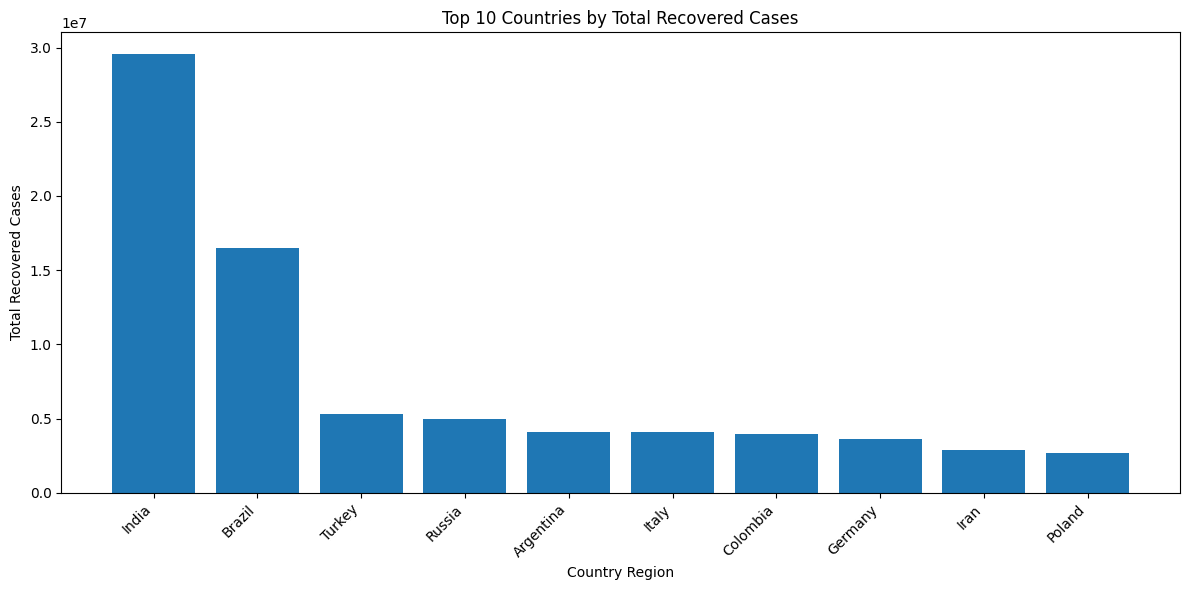

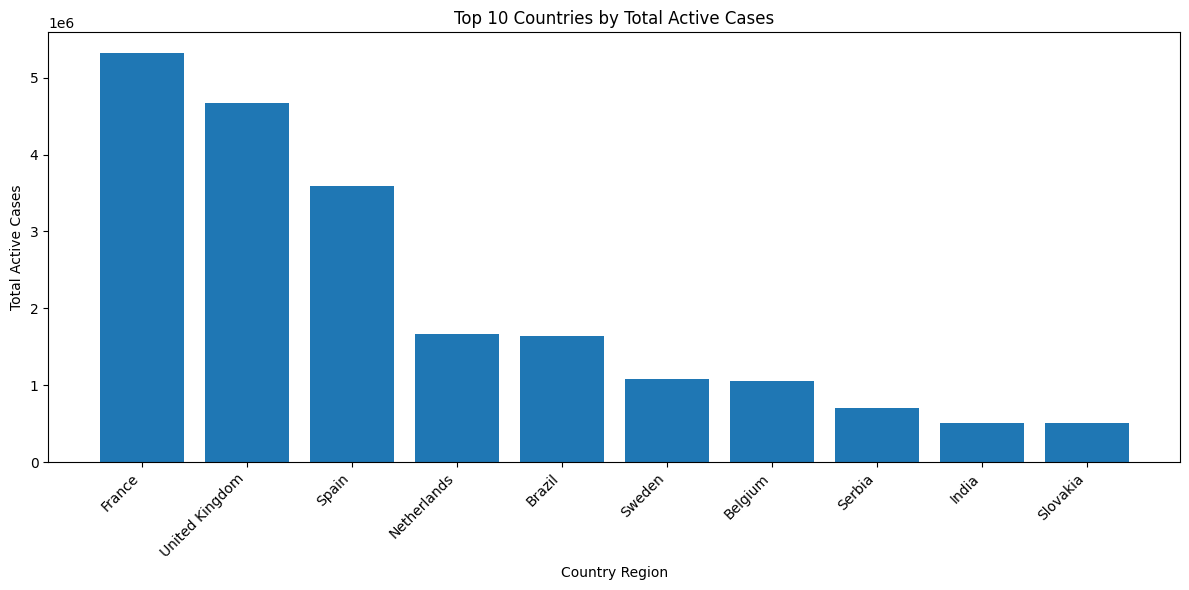

In [12]:
import matplotlib.pyplot as plt

recovered_pd_df = recovered_df.orderBy(col("Total_Recovered").desc()).limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.bar(recovered_pd_df["Country_Region"], recovered_pd_df["Total_Recovered"])
plt.title("Top 10 Countries by Total Recovered Cases")
plt.xlabel("Country Region")
plt.ylabel("Total Recovered Cases")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

active_pd_df = active_df.orderBy(col("Total_Active").desc()).limit(10).toPandas()

plt.figure(figsize=(12, 6))
plt.bar(active_pd_df["Country_Region"], active_pd_df["Total_Active"])
plt.title("Top 10 Countries by Total Active Cases")
plt.xlabel("Country Region")
plt.ylabel("Total Active Cases")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   India, Brazil, and Turkey were identified as the top three countries with the highest total recovered cases.
*   The calculation of active cases involved subtracting deaths and recovered cases from confirmed cases, as an 'Active' column was not initially present in the dataset.
*   Bar charts were successfully generated to visualize the top 10 countries for both total recovered and total active cases.

### Insights or Next Steps

*   Investigate if there's a correlation between the number of recovered cases and the number of active cases across different countries.
*   Explore the trends of recovered and active cases over time for these top countries to understand the progression of the pandemic.
